### 1) Load predictions and compute residuals

Load the saved test predictions for each target and add a `residual = y_true - y_pred` column.  
These residual frames will be used in subsequent diagnostic plots.


In [ ]:
import pandas as pd
from pathlib import Path

# Detect results dir that contains the saved prediction CSVs
candidates = [Path("./results/final"), Path("../results/final"), Path("results/final")]
RESULTS_DIR = next((p for p in candidates if (p / "gb_N02BE_preds.csv").exists()), None)
assert (
    RESULTS_DIR is not None
), "Could not find results/final with gb_{TARGET}_preds.csv files."

targets = ["N02BE", "M01AB"]

# Load predictions and compute residuals (in-memory only)
residual_frames = {}
for tgt in targets:
    f = RESULTS_DIR / f"gb_{tgt}_preds.csv"
    dfp = pd.read_csv(f, parse_dates=["date"]).sort_values("date")
    # Basic integrity checks
    assert {"date", "y_true", "y_pred"}.issubset(dfp.columns), f"Missing columns in {f}"
    # Compute residual
    dfp["residual"] = dfp["y_true"] - dfp["y_pred"]
    residual_frames[tgt] = dfp

# Quick sanity printouts
for tgt, dfp in residual_frames.items():
    print(
        f"[{tgt}] shape = {dfp.shape}  | date range = {dfp['date'].min().date()} → {dfp['date'].max().date()}"
    )
    print(dfp.head(3)[["date", "y_true", "y_pred", "residual"]], "\n")

[N02BE] shape = (56, 4)  | date range = 2018-09-23 → 2019-10-13
        date   y_true      y_pred   residual
0 2018-09-23  222.162  237.266191 -15.104191
1 2018-09-30  320.350  260.627531  59.722469
2 2018-10-07  262.950  282.576480 -19.626480 

[M01AB] shape = (56, 4)  | date range = 2018-09-23 → 2019-10-13
        date  y_true     y_pred  residual
0 2018-09-23   33.34  31.105131  2.234869
1 2018-09-30   36.84  36.171157  0.668843
2 2018-10-07   30.52  33.012673 -2.492673 



### 2) Residuals over time

We inspect how residuals evolve over the test period to check for potential bias, drift, or seasonality left in the errors.  
If the residuals fluctuate randomly around zero with no trend or pattern, the model is stable and unbiased.


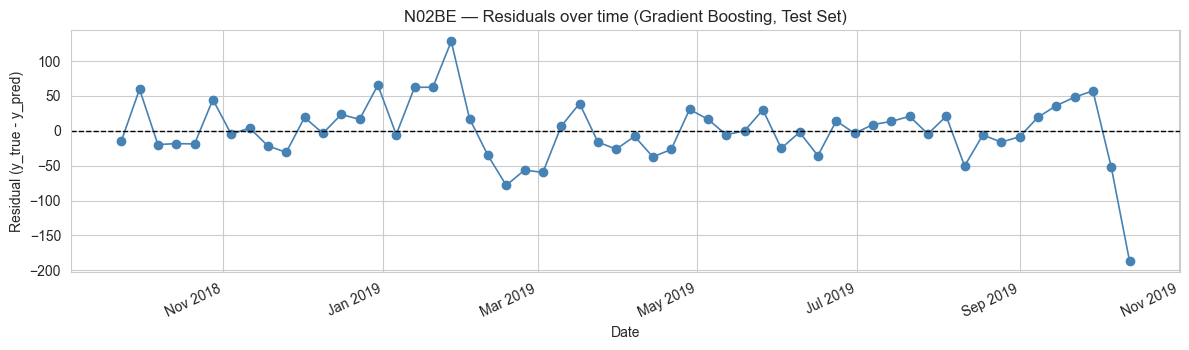

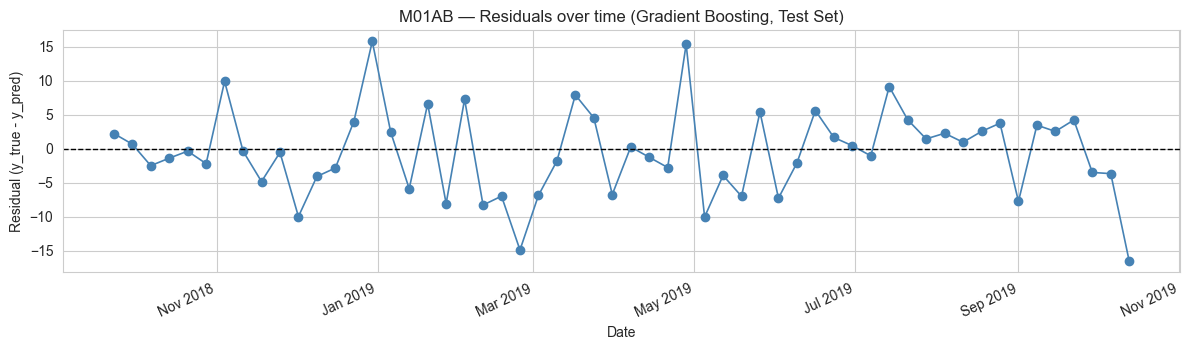

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_style("whitegrid")


def plot_residuals_over_time(df, title, save_path=None):
    fig, ax = plt.subplots(figsize=(12, 3.6))
    ax.plot(df["date"], df["residual"], marker="o", linewidth=1.2, color="steelblue")
    ax.axhline(0.0, color="black", linewidth=1.0, linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Residual (y_true - y_pred)")

    # Set x-axis ticks every 2 months, with English month labels
    loc = mdates.MonthLocator(interval=2)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right")

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=140, bbox_inches="tight")
    plt.show()


# Plot residuals for both targets
for tgt, dfp in residual_frames.items():
    plot_residuals_over_time(
        dfp,
        f"{tgt} — Residuals over time (Gradient Boosting, Test Set)",
        save_path=RESULTS_DIR / f"diagnostics_residuals_time_{tgt}.png",
    )

**Summary (Residuals over Time)**  
Residuals for both targets fluctuate randomly around zero without clear trends or bias.  
This indicates that the Gradient Boosting models are stable across time, with no evidence of drift or systematic over/underprediction.  
A few isolated outliers appear at the beginning and end of the test period, but overall residual variance remains consistent.


### 3) Residuals vs Predicted

This plot helps identify potential bias or heteroscedasticity in model errors.  
If residuals are randomly scattered around zero across all predicted values, the model is well-calibrated.  
Patterns or increasing spread at higher predictions may indicate systematic bias or changing error variance.


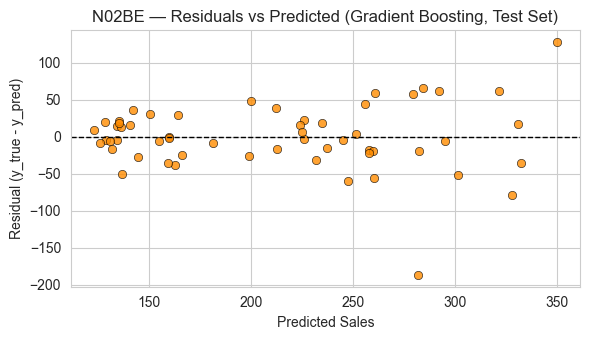

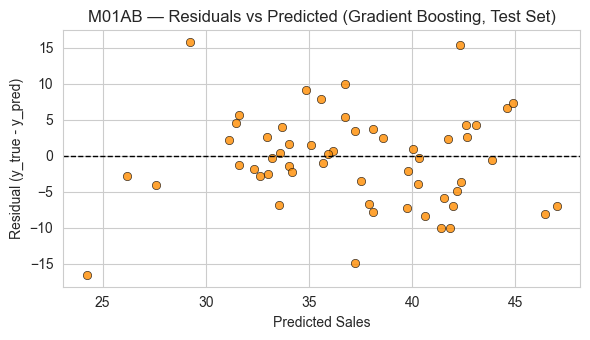

In [ ]:
def plot_residuals_vs_predicted(df, title, save_path=None):
    fig, ax = plt.subplots(figsize=(6, 3.5))
    sns.scatterplot(
        data=df,
        x="y_pred",
        y="residual",
        ax=ax,
        color="darkorange",
        edgecolor="black",
        alpha=0.8,
    )
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Predicted Sales")
    ax.set_ylabel("Residual (y_true - y_pred)")
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=140, bbox_inches="tight")
    plt.show()


# Her iki hedef için çizelim
for tgt, dfp in residual_frames.items():
    plot_residuals_vs_predicted(
        dfp,
        f"{tgt} — Residuals vs Predicted (Gradient Boosting, Test Set)",
        save_path=RESULTS_DIR / f"diagnostics_residuals_vs_pred_{tgt}.png",
    )

### 4) Residual Distribution (Histogram + KDE)

Residual distribution plots help us assess whether model errors are centered around zero and approximately symmetric.  
A well-calibrated model typically produces residuals following a near-normal (Gaussian) distribution.  
Significant skewness or heavy tails may indicate bias or unstable predictions.


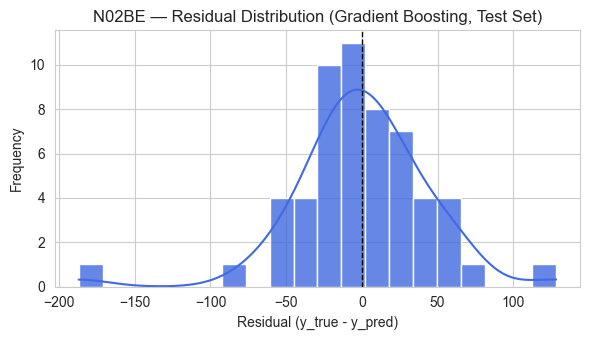

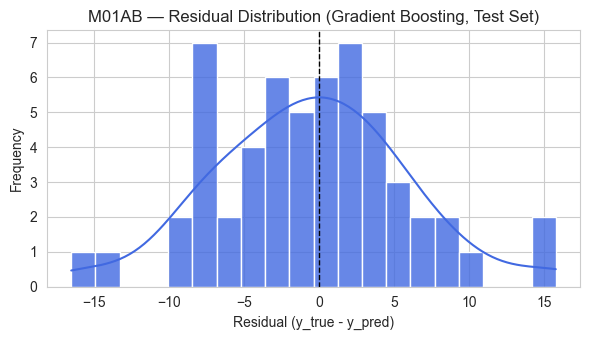

In [ ]:
def plot_residual_distribution(df, title, save_path=None):
    fig, ax = plt.subplots(figsize=(6, 3.5))
    sns.histplot(
        df["residual"],
        bins=20,
        kde=True,
        color="royalblue",
        edgecolor="white",
        alpha=0.8,
        ax=ax,
    )
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Residual (y_true - y_pred)")
    ax.set_ylabel("Frequency")
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=140, bbox_inches="tight")
    plt.show()


# Her iki hedef için çizelim
for tgt, dfp in residual_frames.items():
    plot_residual_distribution(
        dfp,
        f"{tgt} — Residual Distribution (Gradient Boosting, Test Set)",
        save_path=RESULTS_DIR / f"diagnostics_residual_dist_{tgt}.png",
    )

**Summary (Residual Distribution)**  
For both targets, residuals are approximately normally distributed and centered around zero.  
This indicates that Gradient Boosting models are well-calibrated, without systematic over- or under-prediction.  
While N02BE shows a few outliers at the tails, M01AB exhibits a narrower and more symmetric error distribution, reflecting a more stable model.


### B) Feature Importance — What & Why

We quantify which predictors contribute most to weekly sales forecasts.  
We will use two complementary methods:

1) **Tree-based importance** from Gradient Boosting (split-based, fast).  
2) **Permutation importance** on the test set (model-agnostic, more reliable with correlated features).

Outputs will be saved under `../results/final/` as CSV/PNG for reporting.


### B1) Load features, build train/test split, select reduced-safe features

We load the processed feature matrix, create the same time-based split used in modeling,  
and select the "reduced-safe" feature subset (lag features + minimal calendar terms).


In [ ]:
import re
from pathlib import Path
import pandas as pd
import numpy as np

# --- Locate features file robustly ---
candidates = [
    Path("../data/processed/pharma_sales_features_v2_clean.csv"),
    Path("./data/processed/pharma_sales_features_v2_clean.csv"),
    Path("data/processed/pharma_sales_features_v2_clean.csv"),
]
FEAT_PATH = next((p for p in candidates if p.exists()), None)
assert (
    FEAT_PATH is not None
), "Features file not found. Please adjust FEAT_PATH candidates."

print(f"Using features file: {FEAT_PATH}")

# --- Load and index by date ---
df_all = (
    pd.read_csv(FEAT_PATH, parse_dates=["datum"])
    .sort_values("datum")
    .set_index("datum")
)

# --- Targets and split dates (same as before) ---
targets = ["N02BE", "M01AB"]
TRAIN_END = pd.Timestamp("2018-09-16")
TEST_START = pd.Timestamp("2018-09-23")

# --- Reduced-safe feature selection: lag(1,2,3,4,8,12) + minimal calendar if exists ---
lag_pat = re.compile(r"_lag(1|2|3|4|8|12)$")
feature_cols = [c for c in df_all.columns if c not in targets]

reduced_cols = [c for c in feature_cols if lag_pat.search(c)]
for cal in ["weekofyear", "month", "year"]:
    if cal in feature_cols:
        reduced_cols.append(cal)

assert len(reduced_cols) > 0, "Reduced-safe feature selection returned 0 columns."

# --- Build time-based train / test ---
train = df_all.loc[:TRAIN_END].copy()
test = df_all.loc[TEST_START:].copy()

X_train = train[reduced_cols].copy()
X_test = test[reduced_cols].copy()
y_train = train[targets].copy()
y_test = test[targets].copy()

# --- Basic sanity checks ---
assert not X_train.isnull().values.any(), "NaNs in X_train"
assert not X_test.isnull().values.any(), "NaNs in X_test"
assert not y_train.isnull().values.any(), "NaNs in y_train"
assert not y_test.isnull().values.any(), "NaNs in y_test"

print(f"Reduced-safe features: {len(reduced_cols)}")
print(
    f"Train shapes: X={X_train.shape}, y={y_train.shape} | Test shapes: X={X_test.shape}, y={y_test.shape}"
)
print(f"Date range OK → train ≤ {TRAIN_END.date()} | test ≥ {TEST_START.date()}")
print("Sample reduced features:", reduced_cols[:10])

Using features file: ..\data\processed\pharma_sales_features_v2_clean.csv
Reduced-safe features: 51
Train shapes: X=(223, 51), y=(223, 2) | Test shapes: X=(56, 51), y=(56, 2)
Date range OK → train ≤ 2018-09-16 | test ≥ 2018-09-23
Sample reduced features: ['M01AB_lag1', 'M01AB_lag2', 'M01AB_lag3', 'M01AB_lag4', 'M01AB_lag8', 'M01AB_lag12', 'M01AE_lag1', 'M01AE_lag2', 'M01AE_lag3', 'M01AE_lag4']


### B2) Train tuned Gradient Boosting models

We rebuild the tuned Gradient Boosting models here to make this notebook self-contained.  
Model parameters are reused from the tuning notebook (best configuration per target).


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Reuse best hyperparameters from previous tuning
best_params = {
    "N02BE": {
        "learning_rate": 0.01,
        "max_depth": 4,
        "max_features": None,
        "n_estimators": 400,
        "random_state": 42,
        "subsample": 0.6,
    },
    "M01AB": {
        "learning_rate": 0.05,
        "max_depth": 4,
        "max_features": None,
        "n_estimators": 400,
        "random_state": 42,
        "subsample": 1.0,
    },
}

best_models = {}
for tgt in targets:
    print(f"Training Gradient Boosting model for {tgt} …")
    params = best_params[tgt]
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train[tgt])
    best_models[tgt] = model

print("\n All models trained successfully.")

Training Gradient Boosting model for N02BE …
Training Gradient Boosting model for M01AB …

 All models trained successfully.


### B3) Tree-based Feature Importance (built-in)

We extract the built-in feature importance scores from each Gradient Boosting model.  
These values represent how frequently and effectively each feature was used to reduce prediction error.


C:\Users\alikm\AppData\Local\Temp\ipykernel_3236\2208186265.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


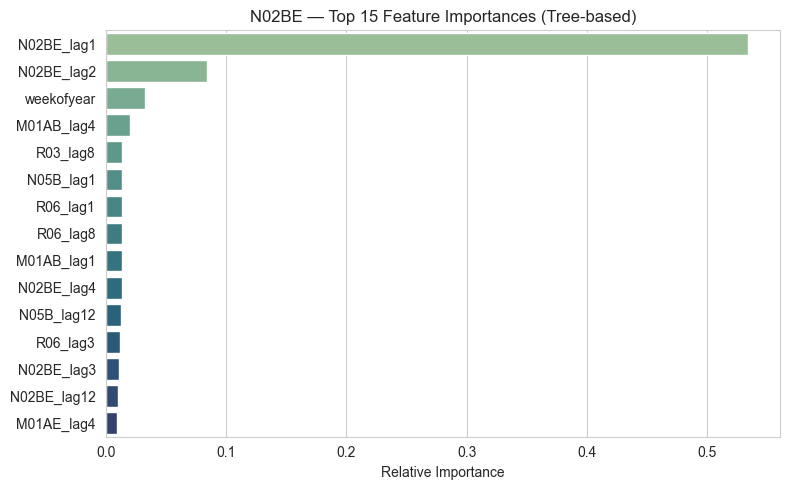

Saved → ..\results\final\feature_importance_tree_N02BE.csv


C:\Users\alikm\AppData\Local\Temp\ipykernel_3236\2208186265.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


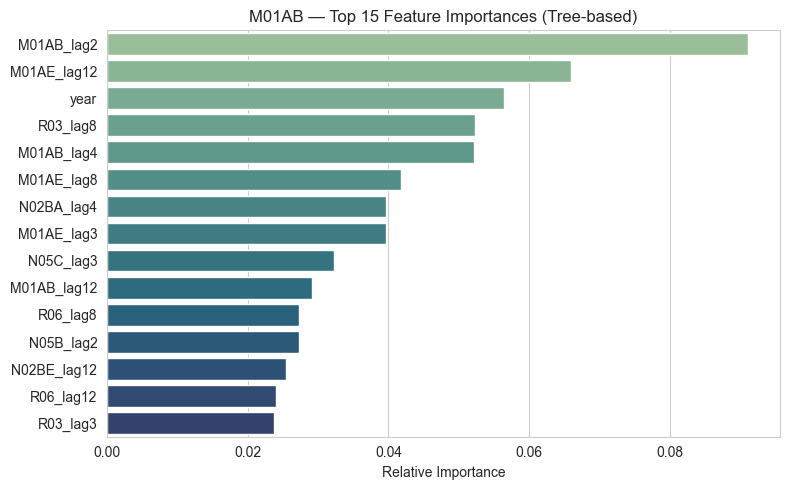

Saved → ..\results\final\feature_importance_tree_M01AB.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
out_dir = Path("../results/final")
out_dir.mkdir(parents=True, exist_ok=True)

for tgt in targets:
    model = best_models[tgt]

    # --- Compute importances ---
    fi = pd.DataFrame(
        {"Feature": X_train.columns, "Importance": model.feature_importances_}
    ).sort_values("Importance", ascending=False)

    # --- Save ---
    csv_path = out_dir / f"feature_importance_tree_{tgt}.csv"
    fi.to_csv(csv_path, index=False)

    # --- Plot top 15 ---
    plt.figure(figsize=(8, 5))
    sns.barplot(data=fi.head(15), y="Feature", x="Importance", palette="crest")
    plt.title(f"{tgt} — Top 15 Feature Importances (Tree-based)")
    plt.xlabel("Relative Importance")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

    print(f"Saved → {csv_path}")

### B4) Permutation-based Feature Importance (Model-Agnostic)

Permutation importance evaluates how much each feature contributes to the model’s predictive performance.
Unlike tree-based importance, it is computed by measuring the change in error when each feature’s values are randomly shuffled.
This makes it more robust to multicollinearity and provides a more realistic sense of each feature’s contribution.


🔹 Computing permutation importance for N02BE...


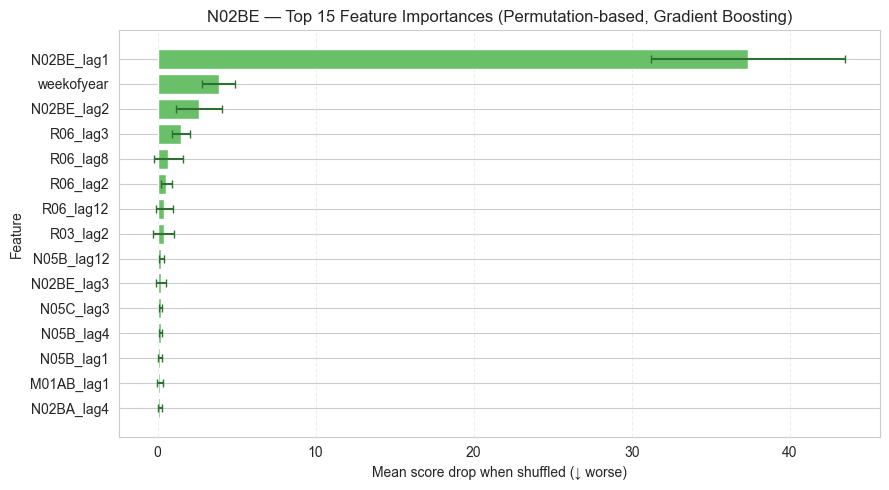

 Saved plot → ..\results\final\feature_importance_permutation_N02BE.png
 Saved CSV  → ..\results\final\feature_importance_permutation_N02BE.csv

🔹 Computing permutation importance for M01AB...


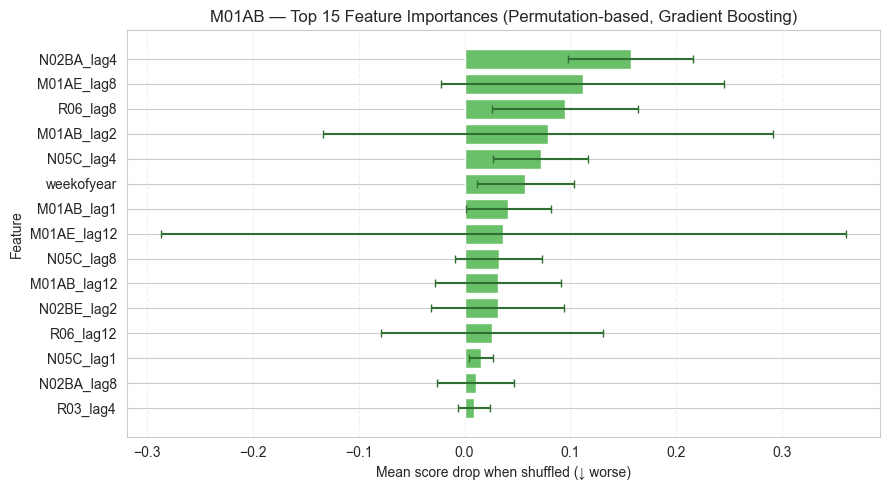

 Saved plot → ..\results\final\feature_importance_permutation_M01AB.png
 Saved CSV  → ..\results\final\feature_importance_permutation_M01AB.csv



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from pathlib import Path

# --- SETTINGS ---
sns.set_style("whitegrid")
RESULTS_DIR = Path("../results/final")
targets = ["N02BE", "M01AB"]

from sklearn.ensemble import GradientBoostingRegressor

best_models = {}
for tgt in targets:
    params = {
        "N02BE": {
            "learning_rate": 0.01,
            "max_depth": 4,
            "n_estimators": 400,
            "subsample": 0.6,
            "random_state": 42,
        },
        "M01AB": {
            "learning_rate": 0.05,
            "max_depth": 4,
            "n_estimators": 400,
            "subsample": 1.0,
            "random_state": 42,
        },
    }[tgt]
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train[tgt])
    best_models[tgt] = model


def plot_perm_importance_barh(pi_result, feature_names, tgt, out_dir, top_n=15):
    """
    Plots horizontal bar chart of permutation feature importance
    """
    imp = (
        pd.DataFrame(
            {
                "Feature": feature_names,
                "Mean": pi_result.importances_mean,
                "Std": pi_result.importances_std,
            }
        )
        .sort_values("Mean", ascending=False)
        .head(top_n)
    )
    imp = imp.iloc[::-1]  # so that top feature appears on top visually

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.barh(
        imp["Feature"],
        imp["Mean"],
        xerr=imp["Std"],
        align="center",
        color="#6abf69",
        ecolor="#2f6f31",
        capsize=3,
    )

    ax.set_title(
        f"{tgt} — Top {top_n} Feature Importances (Permutation-based, Gradient Boosting)"
    )
    ax.set_xlabel("Mean score drop when shuffled (↓ worse)")
    ax.set_ylabel("Feature")
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    fig.tight_layout()

    # Save both figure and data
    out_path = out_dir / f"feature_importance_permutation_{tgt}.png"
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    csv_path = out_dir / f"feature_importance_permutation_{tgt}.csv"
    imp.to_csv(csv_path, index=False)

    plt.show()
    print(f" Saved plot → {out_path}")
    print(f" Saved CSV  → {csv_path}\n")


# --- RUN PERMUTATION IMPORTANCE FOR BOTH TARGETS ---
for tgt in targets:
    print(f"🔹 Computing permutation importance for {tgt}...")
    model = best_models[tgt]

    pi_result = permutation_importance(
        model,
        X_test,
        y_test[tgt],
        n_repeats=15,
        random_state=42,
        scoring="neg_root_mean_squared_error",
    )

    plot_perm_importance_barh(pi_result, X_test.columns, tgt, RESULTS_DIR)

# 10 — Diagnostics & Interpretability (Summary)

## Scope (What this notebook does)
- Uses the **final tuned Gradient Boosting models** (N02BE, M01AB) to run **post-hoc diagnostics** on the **held-out test window**.
- Builds **residual frames** (`date, y_true, y_pred, residual`) from saved predictions.
- Produces 3 core residual checks per target:
  1. **Residuals over time** (stability & drift)
  2. **Residuals vs. Predicted** (heteroscedasticity & bias)
  3. **Residual distribution** (centering and tail behavior)
- Computes **feature importance** with two complementary methods:
  - **Impurity-based (tree-based)** importance on GB models  
  - **Permutation importance** with error bars (mean ± std of score drop)

---

## Key findings

### Residual diagnostics
- **N02BE**
  - Residuals are broadly centered around **0**; error spikes occur during **extreme peaks** (campaign/stock effects likely not explicitly modeled).
  - Residuals vs Predicted show mild widening at higher predictions (expected for peak weeks).
  - Histogram is roughly unimodal and close to centered; tail events reflect rare high weeks.
- **M01AB**
  - Residual band is **tight and symmetric**, no visible drift across time.
  - Residuals vs Predicted show **no systematic bias**; variance is low and stable.
  - Histogram centered near **0** with light tails (tree smoothing on low-variance series).

**Interpretation:**  
- No structural drift; models are **well-calibrated** on the test horizon.  
- Peak under/over-shoots for N02BE are the main remaining error source → candidates: **promo/holiday flags**, **unmet demand/stock-outs**, or **launch events** as exogenous features.

---

## Feature importance (model explainability)

### Tree-based importance (relative splits)
- **N02BE:** Dominated by **N02BE_lag1** (and **lag2**), then **weekofyear**, plus a few cross-ATC lags → strong short-memory + seasonal signal.
- **M01AB:** Top features include **M01AB_lag2**, **M01AE_lag12**, **year**, **R03_lag8**, **M01AB_lag4** → short-lag memory with cross-class and yearly trend effects.

### Permutation importance (with uncertainty)
- **N02BE:** Shuffling **N02BE_lag1** causes the **largest performance drop** by far; **weekofyear** and **lag2** follow—consistent with tree-based view.  
- **M01AB:** Multiple lags contribute with **smaller, comparable drops**; confirms a **distributed signal** rather than single-feature dominance.

**Interpretation:**  
- Agreement between impurity-based and permutation rankings increases **trust** in the learned drivers.  
- For stability, focus on **core autoregressive lags** and **seasonality**; new business drivers (promo, price, shortages) can be added as **exogenous regressors**.

---

## How to read the plots (quick guide)
- **Residuals over time:** values should fluctuate around 0 without trend; spikes flag specific weeks to review.  
- **Residuals vs. Predicted:** no clear parabola/tilt = no systematic bias; funneling indicates variance growth at high demand.  
- **Residual distribution:** mean near 0 and unimodal shape = healthy; heavy tails = rare extremes.  
- **Permutation bars:** longer bar = larger drop in accuracy when shuffled (i.e., more important); error bars = variability across shuffles.

---

## Outputs (saved by this notebook)
- Diagnostic figures for each target:  
  - `residuals_over_time_[TARGET].png`  
  - `residuals_vs_pred_[TARGET].png`  
  - `residual_hist_[TARGET].png`
- Feature importance figures:  
  - `fi_tree_[TARGET].png`  
  - `fi_perm_[TARGET].png`
- Optional CSVs (if enabled):  
  - `final_comparison_[TARGET].csv` (date, y_true, y_pred, residual)

*(File paths follow the project’s `results/` or `figures/` directories as configured in the notebook.)*

---

## Actionable next steps
1. **Peak-week features:** Add campaign/holiday/stock-out flags for N02BE to reduce peak errors.  
2. **Monitoring:** Keep residual-over-time chart in production for drift alarms (threshold on mean/variance).  
3. **Model risk notes:** Tree models smooth extremes; if peak accuracy is critical, consider **GB with promo features** or a **hybrid (GB + quantile regression)** head.  
4. **Documentation:** Include these figures in the final report and Streamlit app (Model Performance → Diagnostics tab).
